In [1]:
import math
import warnings
import numpy as np
import pandas as pd
from data.data import process_data
from keras.models import load_model
# from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
import sklearn.metrics as metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

2023-08-22 11:45:58.551957: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-22 11:45:58.593957: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-22 11:45:58.594908: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 11:45:59.405037: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def MAPE(y_true, y_pred):
    """Mean Absolute Percentage Error
    Calculate the mape.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
    # Returns
        mape: Double, result data for train.
    """

    y = [x for x in y_true if x > 0]
    y_pred = [y_pred[i] for i in range(len(y_true)) if y_true[i] > 0]

    num = len(y_pred)
    sums = 0

    for i in range(num):
        tmp = abs(y[i] - y_pred[i]) / y[i]
        sums += tmp

    mape = sums * (100 / num)

    return mape

In [3]:

def eva_regress(y_true, y_pred):
    """Evaluation
    evaluate the predicted resul.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
    """

    mape = MAPE(y_true, y_pred)
    vs = metrics.explained_variance_score(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print('explained_variance_score:%f' % vs)
    print('mape:%f%%' % mape)
    print('mae:%f' % mae)
    print('mse:%f' % mse)
    print('rmse:%f' % math.sqrt(mse))
    print('r2:%f' % r2)

In [4]:

def plot_results(y_true, y_preds, names):
    """Plot
    Plot the true data and predicted data.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
        names: List, Method names.
    """
    d = '2006-3-4 00:00'
    x = pd.date_range(d, periods=96, freq='15min')

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(x, y_true, label='True Data')
    for name, y_pred in zip(names, y_preds):
        ax.plot(x, y_pred, label=name)

    plt.legend()
    plt.grid(True)
    plt.xlabel('Time of Day')
    plt.ylabel('Flow')

    date_format = mpl.dates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()

    plt.show()


In [5]:

lstm = load_model('model/lstm.h5')
gru = load_model('model/gru.h5')
saes = load_model('model/saes.h5')
models = [lstm, gru, saes]
names = ['LSTM', 'GRU', 'SAEs']

lag = 4
file = 'data/Scats Data October 2006.xls'
_, _, X_test, y_test, flow_scaler, latlong_scaler = process_data(file, lag)
# y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]
# tmp = np.zeros(shape=(len(y_test), 96))
# tmp[:, 0] = y_test.reshape(-1, 1)[:, 0]
# tmp
# flow_scaler.inverse_transform(tmp)[:, 0].reshape(1, -1)[0][0]

2023-08-22 11:46:00.938137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 11:46:00.938693: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
flow_scaler.inverse_transform(y_test.reshape(-1, 1))
# y_test

array([[ 10.],
       [185.],
       [  1.],
       ...,
       [ 34.],
       [  5.],
       [ 23.]])

In [7]:
lstm = load_model('model/lstm.h5')
gru = load_model('model/gru.h5')
saes = load_model('model/saes.h5')
models = [gru]
names = ['LSTM', 'GRU']

lag = 4
file = 'data/Scats Data October 2006.xls'
_, _, X_test, y_test, flow_scaler, latlong_scaler = process_data(file, lag)
y_test = flow_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]

y_preds = []
for name, model in zip(names, models):
    if name == 'SAEs':
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
    else:
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    file = 'images/' + name + '.png'
    plot_model(model, to_file=file, show_shapes=True)
    predicted = model.predict(X_test)
    predicted = flow_scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(1, -1)[0]
    y_preds.append(predicted[:96])
    print(name)
    eva_regress(y_test, predicted)

3144/3144 [==============================] - 10s 3ms/step
LSTM
explained_variance_score:0.434929
mape:170.531129%
mae:45.244503
mse:4266.856611
rmse:65.321180
r2:0.432444


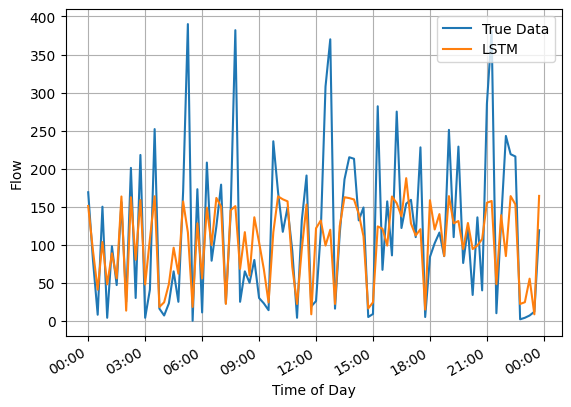

In [8]:
plot_results(y_test[:96], y_preds, names)